# Implement baseline

In [1]:
# Import libraries

# Data processing and manipulation
import pandas as pd
import numpy as np
from tqdm import tqdm
from collections import defaultdict

# Visualization
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D


# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.cluster import KMeans
import xgboost as xgb

# Other
import importlib
import sys, os
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../src')))
import inferenceModels as im
import preprocess_data as ppd
import scenario_generation as sg



# Mutual information
from sklearn.metrics import mutual_info_score
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif



from typing import Iterable
from pathlib import Path

#tests
from scipy.stats import kstest, ks_2samp


from __future__ import annotations

# ── Environment settings (must come before heavy libs) ───────────────────────────
import os
os.environ.setdefault("KMP_DUPLICATE_LIB_OK", "TRUE")
os.environ.setdefault("OMP_NUM_THREADS", "1")
os.environ.setdefault("MKL_NUM_THREADS", "1")
os.environ.setdefault("MKL_SERVICE_FORCE_INTEL", "1")

# ── Standard Library ────────────────────────────────────────────────────────────
import csv
import datetime
import importlib
import itertools
import json
import math
import pickle
import warnings
from collections import deque, defaultdict
from pathlib import Path
from typing import (
    Any, Callable, Dict, Iterable, Literal, List,
    Optional, Sequence, Tuple, Union
)

# ── Third-Party: Core scientific stack ──────────────────────────────────────────
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ── PyTorch (must precede sklearn sometimes for MKL thread settings) ────────────
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
torch.set_num_threads(1)

# ── Scikit-Learn ────────────────────────────────────────────────────────────────
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KernelDensity

# ── XGBoost ─────────────────────────────────────────────────────────────────────
import xgboost as xgb



importlib.reload(im)

<module 'inferenceModels' from '/Users/malo/MIT Dropbox/Malo Lahogue/Research/Generator-outage-probability/src/inferenceModels.py'>

# Data

In [2]:
def load_feature_bases(weather_path: Path, powerload_path: Path) -> list[str]:
    weather = pd.read_csv(weather_path, parse_dates=["datetime"])
    power =  pd.read_csv(powerload_path, parse_dates=["UTC time"])
    base = list(weather.columns) + list(power.columns) + ['Season', 'Month', 'DayOfWeek', 'DayOfYear', 'Holiday', 'Weekend']#, 'Technology']

    # Remove duplicates but keep stable order
    seen = set()
    base = [c for c in base if not (c in seen or seen.add(c))]
    # Drop known non-features if present
    drop = {'datetime', 'UTC time', 'Datetime_UTC', 'Datetime'}
    feats = [c for c in base if c not in drop]
    feats = list(set([(name[0].upper() + name[1:]) if isinstance(name, str) and name else name for name in feats]))
    feats.sort()
    return feats

technology_groups = {'nuclear': ['Nuclear'],
                    'hydro': ['Pumped Storage/Hydro'],
                    'geothermal': ['Geothermal'],
                    'thermal': ['CC GT units ', 
                                'CC steam units', 
                                'Co-generator Block ', 
                                'CoG GT units', 
                                'CoG steam units ', 
                                'Combined Cycle Block', 
                                'Fluidized Bed', 'Fossil-Steam', 
                                'Gas Turbine/Jet Engine (Simple Cycle Operation)', 
                                'Gas Turbine/Jet Engine with HSRG', 
                                'Internal Combustion/Reciprocating Engines',
                                'Multi-boiler/Multi-turbine']}

In [3]:
weather_data_file = "../Data/hourly/hourly_weather_by_state.csv"
power_load_file = "../Data/hourly/hourly_load_by_state.csv"
failure_data_file = "../Data/hourly/hourly_failure_dataset_compressed.csv"

feature_names_base = load_feature_bases(weather_data_file, power_load_file)
# feature_names_base = ['Temperature']
print(f"{len(feature_names_base)} initial features: {feature_names_base}")

test_periods = [(pd.Timestamp('2022-01-01'), pd.Timestamp('2023-12-31'))]
techno = 'thermal'
# technologies = technology_groups[techno]

technologies = ['Gas Turbine/Jet Engine (Simple Cycle Operation)']
state = 'New York'
if 'State' in feature_names_base:
    feature_names_base.remove('State')

38 initial features: ['1d_load_sum', '24h_max_load', '24h_min_load', '2d_load_sum', 'CDD', 'CDD3d', 'DayOfWeek', 'DayOfYear', 'Dew_point_temperature', 'Extreme_cold', 'Extreme_heat', 'FDD', 'FDD3d', 'HDD', 'HDD3d', 'Heat_index', 'Holiday', 'Hourly_load_change', 'Load', 'Month', 'Precip_1d', 'Precip_3d', 'Precipitation', 'Pressure_3hr_change', 'Relative_humidity', 'Sea_level_pressure', 'Season', 'Snow_depth', 'State', 'Station_level_pressure', 'Temperature', 'Tmax', 'Tmean', 'Tmin', 'Weekend', 'Wet_bulb_temperature', 'Wind_chill', 'Wind_speed']


In [4]:
# ---------- Merge + label prep ----------
train_val_df, test_df, feature_names, target_columns, integer_encoding = ppd.preprocess_data(failure_data_path=failure_data_file,
                                                                                            weather_data_path=weather_data_file,
                                                                                            power_load_data_path=power_load_file,
                                                                                            feature_names=feature_names_base,
                                                                                            cyclic_features=["Season", "Month", "DayOfWeek", "DayOfYear"],
                                                                                            state_filter = state,
                                                                                            state_one_hot=False,
                                                                                            initial_MC_state_filter='all',
                                                                                            final_MC_state_target = 'all',
                                                                                            technology_filter=technologies,
                                                                                            technology_one_hot=True,
                                                                                            test_periods=test_periods,
                                                                                            dropNA = True,
                                                                                            feature_na_drop_threshold = 0.2,
                                                                                            )
                                                                            


# subset_length = 100
# train_val_df = train_val_df.iloc[0:subset_length].copy().reset_index(drop=True)
print(f"Train/Val Dataset shape: {train_val_df.shape}")


# Standardize all continuous features (exclude one-hots and raw categorical/cyclic markers)
exclude = {"Holiday", "Weekend", "Season", "Month", "DayOfWeek", "DayOfYear"}
stand_cols = [f for f in feature_names if not f.startswith("State_") and not f.startswith("Technology_") and not f.endswith("_isnan") and not f.endswith("_sin") and not f.endswith("_cos") and f not in exclude]
print(f"Standardized features ({len(stand_cols)}): {stand_cols}")

feature_names.sort()
stand_cols.sort()
target_columns.sort()

Train/Val Dataset shape: (157381, 48)
Standardized features (32): ['FDD3d', 'Precipitation', 'Wind_speed', 'Snow_depth', 'Hourly_load_change', 'Wet_bulb_temperature', '24h_min_load', 'Pressure_3hr_change', 'Extreme_heat', 'HDD', 'CDD', 'Tmean', 'Tmax', 'Heat_index', 'Relative_humidity', 'CDD3d', '2d_load_sum', 'Tmin', '24h_max_load', 'Dew_point_temperature', '1d_load_sum', 'Load', 'HDD3d', 'Temperature', 'Precip_1d', 'Extreme_cold', 'Wind_chill', 'Station_level_pressure', 'Sea_level_pressure', 'Precip_3d', 'FDD', 'Initial_gen_state']


In [6]:
train_val_df_A = train_val_df.loc[train_val_df['Initial_gen_state']==0].copy().reset_index(drop=True)
load_stand_params = pd.read_csv('../DATA/standardization_params_by_state.csv')
train_val_df_A, feature_names  = ppd.preprocess_baseline_logistic_regression_data(train_val_df_A, load_stand_params)

train_val_df_D = train_val_df.loc[train_val_df['Initial_gen_state']!=0].copy().reset_index(drop=True)
load_stand_params = pd.read_csv('../DATA/standardization_params_by_state.csv')
train_val_df_D, feature_names  = ppd.preprocess_baseline_logistic_regression_data(train_val_df_D, load_stand_params)

In [7]:
importlib.reload(im)
importlib.reload(ppd)
mA = im.LogisticRegressionBaseline(verbose=True)
mA.build_model(target_cols=['Final_gen_state'])
mA.prepare_data(train_val_df_A,  split_ratios=(0.8, 0.2))
train_kw = {"batch_size": 512, "burn_in": 10000, "device": "cpu", "early_stopping": True, "epochs": 100, "flat_delta": 2e-05, "flat_mode": "iqr", "flat_patience": 10, "grad_clip_norm": 1.0, "lambda_reg": 0.001, "lr": 0.002, "lr_scheduler": "linear", "min_delta": 1e-05, "optimizer": "adam", "patience": 10, "regularization_type": "L2", "rel_flat": 0.002, "weights_data": True}
mA.train_model(**train_kw)
# mA.train_model(optimizer='adam',
#                regularization_type='L2',
#                lambda_reg=1e-4,
#                epochs=10,
#                batch_size=512,
#                lr=1e-3,
#                weights_data=True,
#                device='cpu',
#                early_stopping=False,
#                lr_scheduler='linear',
            #    )

Epoch 001: train=3.6784e+00 | val=1.6294e+00
Epoch 002: train=5.7587e+00 | val=3.8071e-02
Epoch 003: train=8.1587e-02 | val=8.6149e-02
Epoch 004: train=1.1689e-01 | val=2.2484e-02
Epoch 005: train=8.8140e-02 | val=1.5957e-02
Epoch 006: train=1.3026e-01 | val=8.6836e-03
Epoch 007: train=6.0644e-01 | val=7.4077e-03
Epoch 008: train=5.6236e-01 | val=6.4395e-02
Epoch 009: train=6.6999e-01 | val=1.3934e-02
Epoch 010: train=5.0209e-02 | val=1.1451e-02
Epoch 011: train=4.1166e-01 | val=1.1084e-02
Epoch 012: train=1.2704e-01 | val=1.3681e-02
Epoch 013: train=4.1692e-01 | val=7.1567e-03
Epoch 014: train=1.4845e-01 | val=8.5415e-03
Epoch 015: train=4.7295e-01 | val=7.1779e-03
Epoch 016: train=7.6071e-01 | val=6.6119e-03
Epoch 017: train=7.5474e-01 | val=1.2543e-02
Epoch 018: train=8.7205e-01 | val=6.9542e-01
Epoch 019: train=6.8192e-01 | val=6.6079e-03
Epoch 020: train=6.6196e-01 | val=8.3513e-03
Epoch 021: train=4.3802e-01 | val=6.9707e-03
Epoch 022: train=5.3125e-02 | val=4.0862e+00
Epoch 023:

In [8]:
importlib.reload(im)
importlib.reload(ppd)
mD = im.LogisticRegressionBaseline(verbose=True)
mD.build_model(target_cols=['Final_gen_state'])
mD.prepare_data(train_val_df_D,  split_ratios=(0.8, 0.2))
train_kw = {"batch_size": 512, "burn_in": 10000, "device": "cpu", "early_stopping": True, "epochs": 100, "flat_delta": 2e-05, "flat_mode": "iqr", "flat_patience": 10, "grad_clip_norm": 1.0, "lambda_reg": 0.0005, "lr": 0.0002, "lr_scheduler": "constant", "min_delta": 1e-05, "optimizer": "adam", "patience": 10, "regularization_type": "L2", "rel_flat": 0.002, "weights_data": True}
mD.train_model(**train_kw)

Epoch 001: train=6.4781e+03 | val=6.2390e+03
Epoch 002: train=6.0319e+03 | val=5.7942e+03
Epoch 003: train=5.5870e+03 | val=5.3494e+03
Epoch 004: train=5.1407e+03 | val=4.9046e+03
Epoch 005: train=4.6960e+03 | val=4.4599e+03
Epoch 006: train=4.2499e+03 | val=4.0151e+03
Epoch 007: train=3.8037e+03 | val=3.5703e+03
Epoch 008: train=3.3579e+03 | val=3.1255e+03
Epoch 009: train=2.9125e+03 | val=2.6807e+03
Epoch 010: train=2.4664e+03 | val=2.2360e+03
Epoch 011: train=2.0206e+03 | val=1.7912e+03
Epoch 012: train=1.5752e+03 | val=1.3464e+03
Epoch 013: train=1.1292e+03 | val=9.0162e+02
Epoch 014: train=6.8446e+02 | val=4.5684e+02
Epoch 015: train=2.3878e+02 | val=1.3812e+01
Epoch 016: train=1.1644e+00 | val=6.7170e-01
Epoch 017: train=5.9007e-01 | val=5.9386e-01
Epoch 018: train=5.6605e-01 | val=5.6856e-01
Epoch 019: train=5.3807e-01 | val=5.9676e-01
Epoch 020: train=5.1558e-01 | val=5.1934e-01
Epoch 021: train=4.7812e-01 | val=4.8734e-01
Epoch 022: train=4.5600e-01 | val=4.7175e-01
Epoch 023:

# Generate scenarios

In [9]:
def load_feature_bases(weather_path: Path, powerload_path: Path) -> list[str]:
    weather = pd.read_csv(weather_path, parse_dates=["datetime"])
    power =  pd.read_csv(powerload_path, parse_dates=["UTC time"])
    base = list(weather.columns) + list(power.columns) + ['Season', 'Month', 'DayOfWeek', 'DayOfYear', 'Holiday', 'Weekend']#, 'Technology']

    # Remove duplicates but keep stable order
    seen = set()
    base = [c for c in base if not (c in seen or seen.add(c))]
    # Drop known non-features if present
    drop = {'datetime', 'UTC time', 'Datetime_UTC', 'Datetime'}
    feats = [c for c in base if c not in drop]
    feats = list(set([(name[0].upper() + name[1:]) if isinstance(name, str) and name else name for name in feats]))
    feats.sort()
    return feats

technology_groups = {'nuclear': ['Nuclear'],
                    'hydro': ['Pumped Storage/Hydro'],
                    'geothermal': ['Geothermal'],
                    'thermal': ['CC GT units ', 
                                'CC steam units', 
                                'Co-generator Block ', 
                                'CoG GT units', 
                                'CoG steam units ', 
                                'Combined Cycle Block', 
                                'Fluidized Bed', 'Fossil-Steam', 
                                'Gas Turbine/Jet Engine (Simple Cycle Operation)', 
                                'Gas Turbine/Jet Engine with HSRG', 
                                'Internal Combustion/Reciprocating Engines',
                                'Multi-boiler/Multi-turbine']}

weather_data_file = "../Data/hourly/hourly_weather_by_state.csv"
power_load_file = "../Data/hourly/hourly_load_by_state.csv"
failure_data_file = "../Data/hourly/hourly_failure_test_dataset_2022_2023.csv"

feature_names_base = load_feature_bases(weather_data_file, power_load_file)
print(f"{len(feature_names_base)} initial features: {feature_names_base}")

test_periods = [(pd.Timestamp('2022-01-01'), pd.Timestamp('2023-12-31'))]
techno = 'thermal'
# technologies = technology_groups[techno]
technologies = ['Gas Turbine/Jet Engine (Simple Cycle Operation)']

_, test_df, feature_names_gen, target_columns, integer_encoding = ppd.preprocess_data(failure_data_path="../Data/hourly/hourly_failure_dataset_compressed.csv",
                                                                weather_data_path=weather_data_file,
                                                                power_load_data_path=power_load_file,
                                                                feature_names=feature_names_base,
                                                                cyclic_features=["Season", "Month", "DayOfWeek", "DayOfYear"],
                                                                state_one_hot=True,
                                                                initial_MC_state_filter="all",
                                                                technology_filter=technologies,
                                                                test_periods=test_periods
                                                                )



38 initial features: ['1d_load_sum', '24h_max_load', '24h_min_load', '2d_load_sum', 'CDD', 'CDD3d', 'DayOfWeek', 'DayOfYear', 'Dew_point_temperature', 'Extreme_cold', 'Extreme_heat', 'FDD', 'FDD3d', 'HDD', 'HDD3d', 'Heat_index', 'Holiday', 'Hourly_load_change', 'Load', 'Month', 'Precip_1d', 'Precip_3d', 'Precipitation', 'Pressure_3hr_change', 'Relative_humidity', 'Sea_level_pressure', 'Season', 'Snow_depth', 'State', 'Station_level_pressure', 'Temperature', 'Tmax', 'Tmean', 'Tmin', 'Weekend', 'Wet_bulb_temperature', 'Wind_chill', 'Wind_speed']
'State' in merged_data.columns : True
'State' in merged_data.columns : True


In [11]:
test_scenario_generation_data_logistic, feat_logist = ppd.preprocess_baseline_logistic_regression_data(test_df.loc[test_df['State_NEW YORK'] == 1].copy().reset_index(drop=True), load_stand_params)


In [12]:
test_scenario_generation_data_logistic = test_scenario_generation_data_logistic[['Datetime_UTC']+feat_logist].drop_duplicates()

In [13]:
test_failures_df = pd.read_csv("../Data/hourly/hourly_failure_test_dataset_2022_2023.csv", parse_dates=['Datetime_UTC'])


In [14]:
historical_scenario_by_state = {}
for state in tqdm(['New York'], desc="Aggregating historical scenarios by state"):
    state_failures_df = test_failures_df[test_failures_df['State'] == state].copy()
    state_failures_df = state_failures_df[state_failures_df['Technology'].isin(technologies)].copy()
    state_scenario_df = sg.aggregate_scenario(state_failures_df)
    historical_scenario_by_state[state] = state_scenario_df

Aggregating historical scenarios by state: 100%|██████████| 1/1 [00:02<00:00,  2.49s/it]


## Scenario Inputs

In [15]:
def clean_state_name(state_col: str) -> str:
    s = state_col.split('_')[1]
    clean_s = ''
    for w in s.split( ' '):
        clean_s += w.capitalize() + ' '
    state = clean_s.strip()
    return state


In [16]:

def get_scenario_inputs(feature_inputs_df, test_failures_df):
    scenarios_inputs_by_state = {}

    for s in tqdm([c for c in feature_inputs_df.columns if c.startswith('State_')], desc="Getting feature inputs by state"):
        state = clean_state_name(s)
        scenarios_inputs_by_state[state] = feature_inputs_df.loc[feature_inputs_df[s] == 1].drop_duplicates().sort_values('Datetime_UTC').copy()

    generators_per_state = {}
    for state in tqdm(test_failures_df['State'].unique(), desc="Getting generators by state"):
        state_failures_df = test_failures_df[test_failures_df['State'] == state].copy()
        state_gens = {'UnitID': [], 'Technology': [], 'Start_date': [], 'End_date': []}
        for unitID, unit_df in state_failures_df.groupby('UnitID'):
            start = unit_df['Datetime_UTC'].min()
            end = unit_df['Datetime_UTC'].max()
            state_gens['UnitID'].append(unitID)
            state_gens['Technology'].append(unit_df['Technology'].iloc[0])
            state_gens['Start_date'].append(start)
            state_gens['End_date'].append(end)

        generators_per_state[state] = pd.DataFrame(state_gens)

    return scenarios_inputs_by_state, generators_per_state


In [17]:
test_scenario_generation_data_logistic['State_NEW YORK'] = 1


In [18]:
scenarios_inputs_by_state, generators_per_state = get_scenario_inputs(test_scenario_generation_data_logistic, test_failures_df)


Getting generators by state: 100%|██████████| 55/55 [01:51<00:00,  2.02s/it]


In [24]:
class trans_prob_logist:
    def __init__(self, model_A: im.LogisticRegressionBaseline, model_D: im.LogisticRegressionBaseline):
        self.model_A = model_A
        self.model_D = model_D

    def predict(self, X: pd.DataFrame) -> np.ndarray:
        predA = self.model_A.predict(X).flatten()
        predD = self.model_D.predict(X).flatten()
        # Combine predictions into transition probability
        probs = np.empty((2, X.shape[0], 2))
        probs[0, :, 1] = predA  # P(A->D)
        probs[0, :, 0] = 1 - predA  # P(A->A)
        probs[1, :, 1] = predD  # P(D->D)
        probs[1, :, 0] = 1 - predD  # P(D->A)
        return probs


In [21]:
cov, feat_logistic =  ppd.preprocess_baseline_logistic_regression_data(scenarios_inputs_by_state['New York'], load_stand_params)

KeyError: 'Final_gen_state'

In [25]:
prob_model = trans_prob_logist(mA, mD)
# p = prob_model.predict(cov)
# p.mean(axis=1)

In [22]:

def get_stationary_distribution(transition_probability_matrix: np.ndarray) -> np.ndarray:
    """Computes the stationary distribution of a Markov chain given its transition probability matrix.
    INPUTS:
    - transition_probability_matrix: 2D numpy array of shape (n_states, n_states)
    OUTPUTS:
    - stationary_distribution: 1D numpy array of shape (n_states,)
    """
    assert transition_probability_matrix.ndim == 2, "Transition probability matrix must be 2D"
    assert transition_probability_matrix.shape[0] == transition_probability_matrix.shape[1], "Transition probability matrix must be square"
    
    n_states = transition_probability_matrix.shape[0]
    A = np.transpose(transition_probability_matrix) - np.eye(n_states)
    A = np.vstack([A, np.ones(n_states)])
    b = np.zeros(n_states + 1)
    b[-1] = 1.0

    A = A.astype(float)
    b = b.astype(float)

    stationary_distribution, residuals, rank, s = np.linalg.lstsq(A, b, rcond=None)
    return stationary_distribution

def generate_unavailable_capacity_scenario_per_gen(
    covariates_inputs_df: pd.DataFrame,
    generators_data_df: pd.DataFrame,
    transition_model: dict,
    num_scenarios: int = 1000,
    min_scenarios_per_gen: int = 10,
) -> dict:
    """
    Generate per-generator state scenarios from ML-based transition models.

    Internals:
    - Uses integer encoding for states: 0 -> 'A', 1 -> 'D', 2 -> 'U'.
    - Vectorizes:
        * Transition probabilities into a (3, T, 3) array.
        * Scenario simulation over K scenarios per generator.

    INPUTS:
    - covariates_inputs_df : DataFrame with columns
        ['Datetime_UTC'] + features needed by each model.
      Must be sorted by Datetime_UTC (if not, we sort internally).
    - generators_data_df : DataFrame with at least columns
        ['UnitID', 'Start date', 'End date'].
    - models : dict mapping initial-state label -> fitted model, e.g.
        {'A': model_A, 'D': model_D, 'U': model_U}
      Each model must expose `.feature_cols` and `.predict(X)` returning
      probs with columns ordered as [P(A), P(D), P(U)].
    - num_scenarios : Target number of *aggregate* scenarios. We generate
      K scenarios per generator such that K^G ≳ num_scenarios, where
      G = number of generators.

    OUTPUT:
    - scenarios_per_gen : dict[unit_id -> list[pd.DataFrame]]
        Each DataFrame has columns ['Datetime_UTC', 'Gen_state', 'UnitID'].
    """
    # ---- State encoding ----
    state_labels = ["A", "D"]
    label_to_idx = {s: i for i, s in enumerate(state_labels)}
    idx_to_label = {i: s for s, i in label_to_idx.items()}
    idx_to_label[-1] = "N/A"  # for uninitialized states
    n_states = len(state_labels)

    # ---- Ensure time ordering + extract times as numpy ----
    cov_df = covariates_inputs_df.sort_values("Datetime_UTC").reset_index(drop=True)
    times = cov_df["Datetime_UTC"].to_numpy()
    T = len(times)

    # ---- Precompute transition probabilities as numpy array ----
    # P_all[from_state, t, to_state] with shape (3, T, 3)
    P_all = transition_model.predict(cov_df)
    # P_all = np.empty((n_states, T, n_states), dtype=np.float64)

    # for from_label, model in models.items():
    #     if from_label not in label_to_idx:
    #         raise KeyError(f"Unexpected initial state key in models: {from_label}")
    #     from_idx = label_to_idx[from_label]

    #     X_inputs = cov_df[model.feature_cols]
    #     probs = np.asarray(model.predict(X_inputs), dtype=np.float64)  # (T, 3)

    #     if probs.ndim != 2 or probs.shape[1] != n_states:
    #         raise ValueError(
    #             f"Model for state {from_label} must return (T, {n_states}) "
    #             f"probability array; got shape {probs.shape}."
    #         )

    #     # Normalize defensively to avoid any numerical drift
    #     row_sums = probs.sum(axis=1, keepdims=True)
    #     # If any row sum is zero, fall back to uniform
    #     probs = np.divide(
    #         probs,
    #         row_sums,
    #         out=np.full_like(probs, 1.0 / n_states),
    #         where=row_sums > 0,
    #     )
    #     P_all[from_idx, :, :] = probs

    # ---- How many scenarios per generator? ----
    # num_scenarios_per_gen ** num_generators >= num_scenarios 
    num_generators = max(1, len(generators_data_df))
    num_scenarios_per_gen = int(np.ceil(num_scenarios ** (1.0 / num_generators)))
    num_scenarios_per_gen = max(num_scenarios_per_gen, min_scenarios_per_gen)

    rng = np.random.default_rng()

    scenarios_per_gen: dict = {}

    # ---- Loop over generators (outer loop only, time & scenarios are vectorized) ----
    for unit in tqdm(
        generators_data_df.itertuples(index=False),
        total=len(generators_data_df),
        desc="Generating per unit scenarios"):
        
        # Expect these attribute names to match DataFrame column names
        unit_id = getattr(unit, "UnitID")
        start_date = getattr(unit, "Start_date")
        end_date = getattr(unit, "End_date")

        # Mask time window for this unit
        mask = (times >= start_date) & (times <= end_date)
        idx = np.nonzero(mask)[0]
        if idx.size == 0:
            # No coverage for this unit in covariate time grid
            scenarios_per_gen[unit_id] = []
            continue

        idx_start = idx[0]
        idx_end = idx[-1] + 1  # slice end (exclusive)
        # times_unit = times[idx_start:idx_end]
        # T_u = len(times_unit)

        # Slice transition probs for this unit: shape (3, T_u, 3)
        # P_unit = P_all[:, idx_start:idx_end, :]

        # ---- Initial stationary distribution at t=0 from P_unit[:,0,:] ----
        trans0 = P_all[:, idx_start:idx_start+72, :].mean(axis=1)  # (3, 3)
        pi0 = get_stationary_distribution(trans0)  # (3,)

        # Clip + renormalize for numerical safety
        pi0 = np.clip(pi0, 0.0, None)
        s = pi0.sum()
        if s <= 0:
            pi0 = np.array([1.0, 0.0, 0.0], dtype=np.float64)
        else:
            pi0 = pi0 / s

        K = num_scenarios_per_gen
        # simulate only inside [idx_start, idx_end)
        states = np.full((K, T), -1, dtype=np.int8)

        # initial state at idx_start
        states[:, idx_start] = rng.choice(n_states, size=K, p=pi0)

        # ---- Inhomogeneous Markov chain simulation (vectorized over K) ----
        for t in range(idx_start+1, idx_end):
            last_states = states[:, t - 1]  # shape (K,)

            # Gather transition rows for each scenario:
            # P_unit[from_state, t, :] -> (K, 3)
            probs_t = P_all[last_states, t, :]  # (K, 3)

            # Renormalize each row just in case
            row_sums = probs_t.sum(axis=1, keepdims=True)
            probs_t = np.divide(
                probs_t,
                row_sums,
                out=np.full_like(probs_t, 1.0 / n_states),
                where=row_sums > 0,
            )

            # Sample next states with inverse-CDF trick
            u = rng.random(size=K)
            cdf = probs_t.cumsum(axis=1)  # (K, 3)
            # new_state = first j s.t. u <= cdf[j]; equivalent to count of (u > cdf)
            new_states = (u[:, None] > cdf).sum(axis=1).astype(np.int8)
            states[:, t] = new_states
        # ---- Convert integer states back to 'A'/'D'/'U' per scenario ----
        unit_scenarios = []
        for k in range(K):
            gen_state_labels = [idx_to_label[int(s)] for s in states[k]]
            df_k = pd.DataFrame(
                {
                    "Datetime_UTC": times,
                    "Gen_state": gen_state_labels,
                    "UnitID": unit_id,
                }
            )
            unit_scenarios.append(df_k)
        scenarios_per_gen[unit_id] = unit_scenarios
        
    return scenarios_per_gen


def generate_unavailable_capacity_scenario(
    scenarios_per_gen: dict,
    num_scenarios: int = 1,
    seed: int = 42
):
    """
    Combine per-generator scenarios into aggregated unavailable capacity scenarios.
    Vectorized version.

    INPUT:
        scenarios_per_gen: dict[unitID -> list[pd.DataFrame]]
        num_scenarios: how many aggregated scenarios to produce
    OUTPUT:
        list of pd.DataFrame, each with:
            ['Datetime_UTC', 'Unavailable_capacity', 'Unavailable_capacity (%)']
    """
    rng = np.random.default_rng(seed)

    # ---- 1) Convert per-gen scenarios into uniform integer-coded arrays ----
    unit_ids = list(scenarios_per_gen.keys())
    G = len(unit_ids)

    # Determine the global time axis T
    # (all generators must share exact same Datetime_UTC grid)
    all_timesteps = set()
    for scen_list_gen in scenarios_per_gen.values():
        # Assume all scenarios for a given gen share the same time axis
        all_timesteps.update(scen_list_gen[0]['Datetime_UTC'].to_numpy())

    times = np.sort(np.array(list(all_timesteps)))
    T = len(times)

    # Build (G, K, T) integer matrix of states
    # Where each entry is 0, 1, or 2
    state_label_to_int = {"A": 0, "D": 1, "N/A": -1}

    K_per_gen = [len(scenarios_per_gen[u]) for u in unit_ids]
    if len(set(K_per_gen)) != 1:
        raise ValueError("All generators must have same number of per-gen scenarios.")

    K = K_per_gen[0]

    states = np.empty((G, K, T), dtype=np.int8)

    for gi, unit in enumerate(unit_ids):
        dfs = scenarios_per_gen[unit]
        for k, df in enumerate(dfs):
            if len(df) != df['Datetime_UTC'].nunique():
                raise ValueError(f"Duplicate Datetime_UTC entries found for UnitID {unit}")
            states[gi, k, :] = df["Gen_state"].map(state_label_to_int).to_numpy()

    # ---- 2) Randomly select which gen-scenario each generator uses in each agg scenario ----
    # choices: shape (num_scenarios, G), each ∈ {0...K-1}
    choices = rng.integers(0, K, size=(num_scenarios, G))

    # ---- 3) Build aggregated state tensor ----
    # Combine by selecting states[gen_idx, choice[scenario,gen], :]
    # Result: shape (num_scenarios, G, T)
    agg_states = np.empty((num_scenarios, G, T), dtype=np.int8)
    for si in range(num_scenarios):
        for gi in range(G):
            agg_states[si, gi, :] = states[gi, choices[si, gi], :]

    # ---- 4) Convert aggregated states to unavailable capacity ----
    #  state=2 (U): contributes 1.0
    #  state=1 (D): contributes α (sampled per derate block)
    #  state=0 (A): contributes 0
    #
    # First mark U contribution:
    # U_mask = (agg_states == 2).astype(np.float32)

    # Next handle derates
    D_mask = (agg_states == 1)

    # Existing generator
    E_mask = (agg_states >= 0)

    # For each derate "block" (contiguous sequence), sample α ∈ [0.15,1]
    # block detection: diff along time axis
    scenarios_list = []
    for si in tqdm(range(num_scenarios),
                   total=num_scenarios,
                   desc="Generating unavailable capacity scenarios"):
        # α vector for (G,T)
        alpha_vals = np.zeros((G, T), dtype=np.float32)

        for gi in range(G):
            d = D_mask[si, gi, :]
            # detect transitions
            dd = np.diff(d.astype(np.int8), prepend=0)
            starts = np.where(dd == 1)[0]
            ends   = np.where(dd == -1)[0]
            if d[-1] == 1:
                ends = np.append(ends, T)

            for s, e in zip(starts, ends):
                # a = rng.uniform(0.15, 1.0)
                alpha_vals[gi, s:e] = 0.78

        # unavailable capacity per generator
        # gen_unavail = U_mask[si] + alpha_vals
        gen_unavail = alpha_vals

        # sum over generators
        u = gen_unavail.sum(axis=0)
        pct = (u / E_mask[si].sum(axis=0)) * 100

        df = pd.DataFrame({
            "Datetime_UTC": times,
            "Unavailable_capacity": u,
            "Unavailable_capacity (%)": pct
        })
        scenarios_list.append(df)

    return scenarios_list

In [26]:
transition_prob_models = {"Logistic_regression": prob_model}

In [27]:
states_to_plot = ['New York']

In [28]:
importlib.reload(sg)

generated_scenarios_by_state = {}

for state in states_to_plot:
    generated_scenarios_by_state[state] = {}
    for model_name, model in transition_prob_models.items():
        print(f"Generating scenarios for state: {state}, model: {model_name}")

        covariates_inputs_df = scenarios_inputs_by_state[state]#preprocess_baseline_logistic_regression_data(scenarios_inputs_by_state[state], ny_state_params)[0]
        generators_data_df = generators_per_state[state]
        generators_data_df = generators_data_df.loc[generators_data_df['Technology'].isin(technologies)].copy()

        scenarios_per_gen = generate_unavailable_capacity_scenario_per_gen(covariates_inputs_df,
                                                                                generators_data_df,
                                                                                transition_model=model,
                                                                                # transition_prob_models['Frequency_Model'],
                                                                                # models_states[state],
                                                                                num_scenarios=1000,
                                                                                )
        
        generated_scenarios = generate_unavailable_capacity_scenario(scenarios_per_gen, 
                                                            num_scenarios=1000
                                                            )
        generated_scenarios_by_state[state][model_name] = generated_scenarios


Generating scenarios for state: New York, model: Logistic_regression


Generating unavailable capacity scenarios: 100%|██████████| 1000/1000 [00:06<00:00, 152.50it/s]


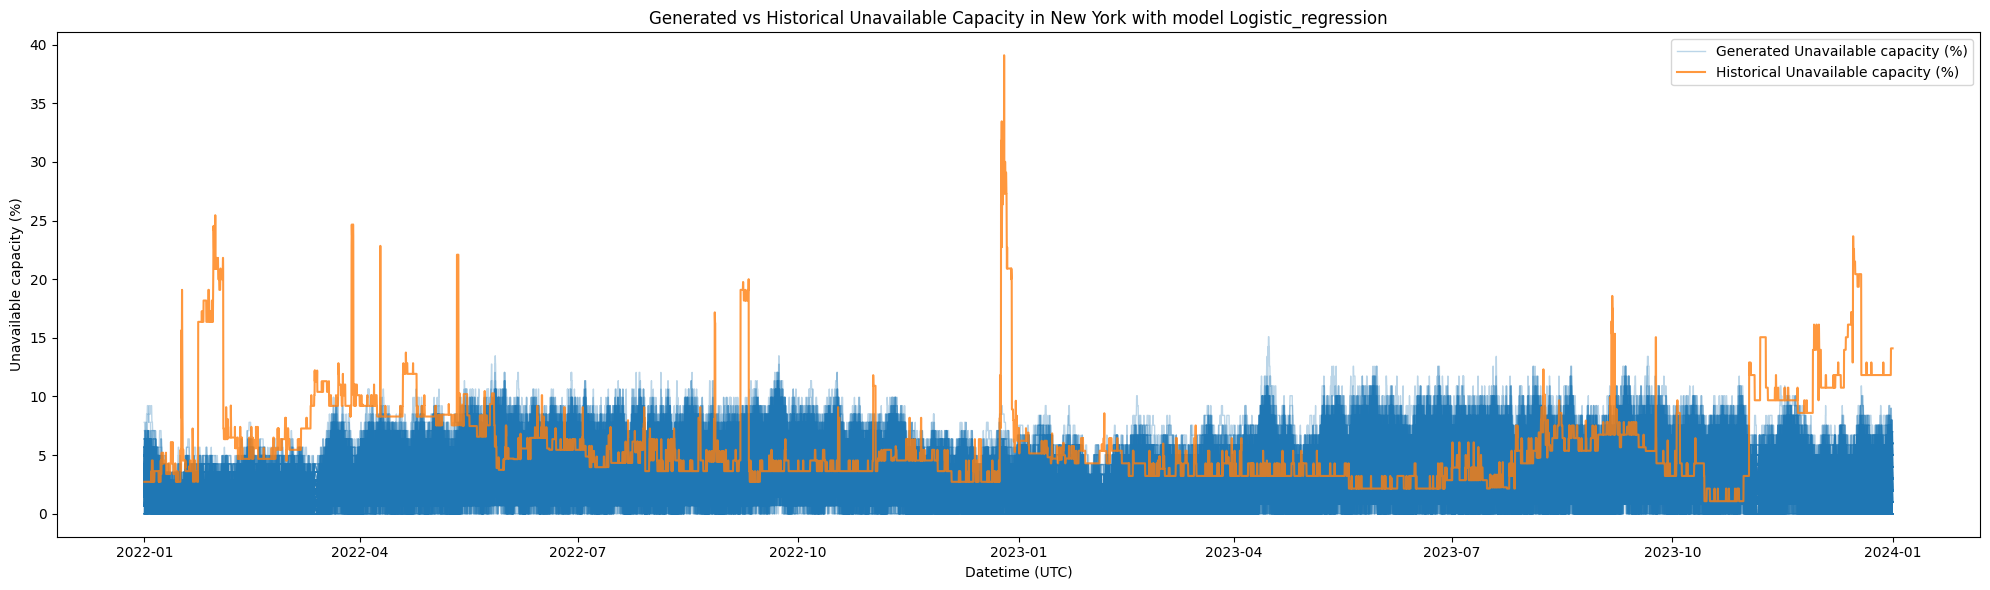

In [29]:
n_plots = sum([1 for v in generated_scenarios_by_state.values() for _ in v])
fig, axs = plt.subplots(n_plots, 1, figsize=(20, 6*n_plots), sharex=True)

for i, state in enumerate(states_to_plot):
    for j, (model_name, scenarios) in enumerate(generated_scenarios_by_state[state].items()):
        if n_plots == 1:
            ax = axs
        else:
            ax = axs[i+j]
        for k, sc in enumerate(scenarios):
            dt = sc['Datetime_UTC'].to_numpy(dtype='datetime64[ns]')
            unavailable_capacity = sc['Unavailable_capacity (%)'].to_numpy()
            if k == 0:
                ax.plot(dt, unavailable_capacity, color='tab:blue', linewidth=1, alpha=0.3, label='Generated Unavailable capacity (%)')
            else:
                ax.plot(dt, unavailable_capacity, color='tab:blue', linewidth=1, alpha=0.3)


        historical_scenario_df = historical_scenario_by_state[state]
        historical_unavailable_capacity = historical_scenario_df['Unavailable_capacity (%)'].to_numpy()
        historical_dt = historical_scenario_df['Datetime_UTC'].to_numpy(dtype='datetime64[ns]')
        ax.plot(historical_dt, historical_unavailable_capacity, color='tab:orange', label='Historical Unavailable capacity (%)', alpha=0.8)

        ax.set_title(f'Generated vs Historical Unavailable Capacity in {state} with model {model_name}')
        ax.set_xlabel('Datetime (UTC)')
        ax.set_ylabel('Unavailable capacity (%)')
        ax.legend(loc='best')
plt.tight_layout()

In [219]:
prob_model = trans_prob_logist(mA, mD)
p = prob_model.predict(cov)


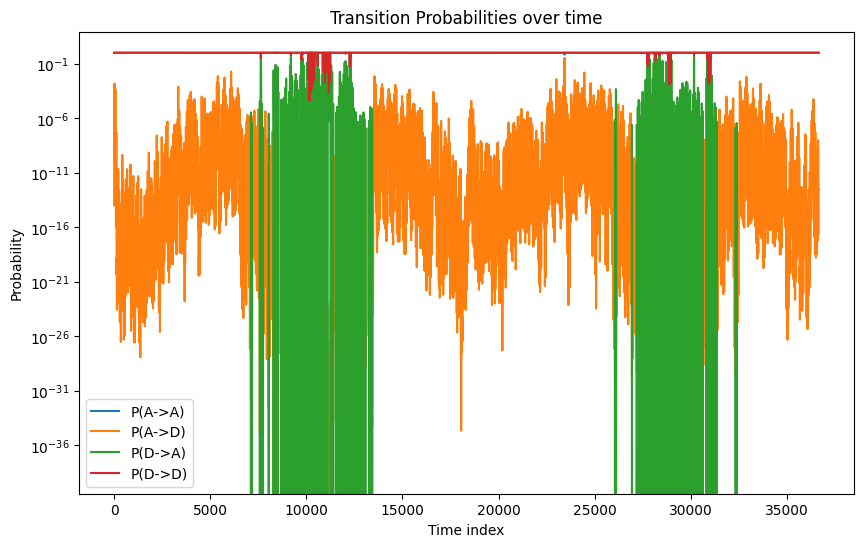

In [222]:
pAA  = p[0, :, 0]
pAD  = p[0, :, 1]
pDA  = p[1, :, 0]
pDD  = p[1, :, 1]

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(pAA, label='P(A->A)')
ax.plot(pAD, label='P(A->D)')
ax.plot(pDA, label='P(D->A)')
ax.plot(pDD, label='P(D->D)')
ax.set_title('Transition Probabilities over time')
ax.set_xlabel('Time index')
ax.set_ylabel('Probability')
ax.set_yscale('log')
ax.legend(loc='best')
        # --- handle lambda_reg ---